In [1]:
## support random class selection
## support shuffle
## support confusion matrix

import tensorflow as tf
import numpy as np
import cifar10_utils
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.applications import VGG16
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

num_classes = 10
image_shape = x_train.shape[1:]

#training
batch_size = 100
base_epochs = 1

baseMapNum = 32
weight_decay = 1e-4
class_names = ['other', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

seed = 123
np.random.seed(seed)

model = cifar10_utils.create_base_model(image_shape, baseMapNum, weight_decay, 'kaggle')
model.summary()
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

selected classes: ['deer', 'horse', 'dog']
current other class: [ 1  2  3  4  7  9 10]
current target class: [5 8 6]
all target target class: [5 8 6]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 5000
(15000,) (5000,)
sequence of class addition: ['deer', 'horse', 'dog']

======Training From Scratch=========

[0.5769999951124192, 0.4889999955892563, 0.846999990940094]


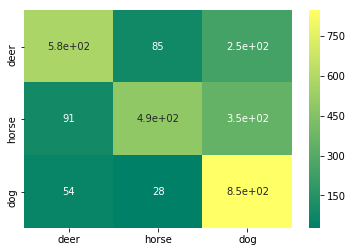

sequence of class addition: ['deer', 'dog', 'horse']

======Training From Scratch=========

[0.7040000021457672, 0.5400000035762786, 0.8260000050067902]


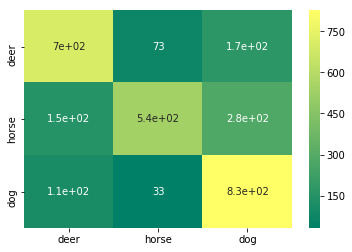

sequence of class addition: ['horse', 'deer', 'dog']

======Training From Scratch=========

[0.81700000166893, 0.4979999899864197, 0.7020000040531158]


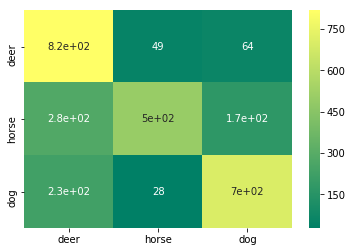

sequence of class addition: ['horse', 'dog', 'deer']

======Training From Scratch=========

[0.3989999979734421, 0.7320000052452087, 0.7790000081062317]


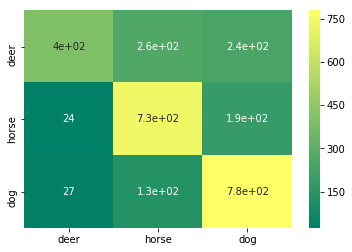

sequence of class addition: ['dog', 'deer', 'horse']

======Training From Scratch=========

[0.38799999952316283, 0.3170000076293945, 0.7789999961853027]


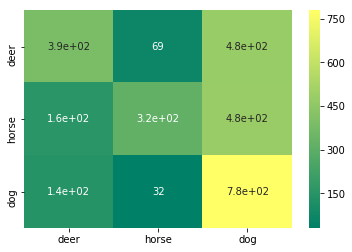

sequence of class addition: ['dog', 'horse', 'deer']

======Training From Scratch=========

[0.7490000069141388, 0.589999994635582, 0.664000004529953]


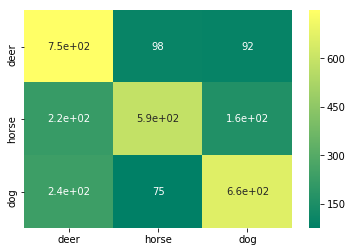

In [3]:
num_classes_excluding_other = 3
full_class_ids = np.arange(1, 11)  # 1-10
np.random.shuffle(full_class_ids)

full_target_class_ids = full_class_ids[:num_classes_excluding_other]

print('selected classes: ' + str([class_names[el] for el in full_target_class_ids]))

full_target_class_ids_all_permutation = list(itertools.permutations(full_target_class_ids))

cur_target_class_ids = np.copy(full_target_class_ids)
(cur_train_data, cur_train_labels) = cifar10_utils.generate_data(cur_target_class_ids, full_target_class_ids, 
                                                               x_train, y_train, False, seed)

for full_target_class_ids_eli in full_target_class_ids_all_permutation: 
    print('sequence of class addition: ' + str([class_names[el] for el in full_target_class_ids_eli]))
    cifar10_utils.one_run(model, cur_train_data, cur_train_labels, x_test, y_test, batch_size, full_target_class_ids_all_permutation[0], initial_weights, base_epochs, datagen, class_names)
#         cifar10_utils.one_run(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids_all_permutation[0], initial_weights, base_epochs, datagen, class_names)

In [4]:
x = np.array([5,21,11,2,2,2,5,25,1,1])
unique, counts = np.unique(x, return_counts=True)
print(counts)
print(np.asarray((unique, counts)).T)

[2 3 2 1 1 1]
[[ 1  2]
 [ 2  3]
 [ 5  2]
 [11  1]
 [21  1]
 [25  1]]


[[ 44 869  46  41]
 [ 29  45 874  52]
 [ 67  68  67 798]]


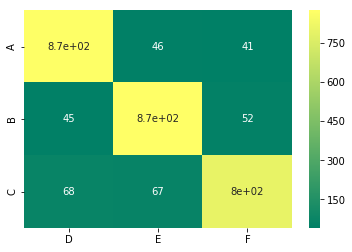

In [5]:
import seaborn as sn
import pandas as pd

a = np.array([[44, 869, 46, 41], [29, 45, 874, 52], [67, 68, 67, 798]])
print(a)

df_cm = pd.DataFrame(a[:, 1:], index = [i for i in "ABC"],
                  columns = [i for i in "DEF"])
plt.figure()
sn.heatmap(df_cm, annot=True, cmap='summer')